# Nonparametric ML Models - Cumulative Lab

## Introduction

In this cumulative lab, you will apply two nonparametric models you have just learned — k-nearest neighbors and decision trees — to the forest cover dataset.

## Objectives

* Practice identifying and applying appropriate preprocessing steps
* Perform an iterative modeling process, starting from a baseline model
* Explore multiple model algorithms, and tune their hyperparameters
* Practice choosing a final model across multiple model algorithms and evaluating its performance

## Your Task: Complete an End-to-End ML Process with Nonparametric Models on the Forest Cover Dataset

![line of pine trees](images/trees.jpg)

Photo by <a href="https://unsplash.com/@michaelbenz?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Michael Benz</a> on <a href="/s/photos/forest?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

### Business and Data Understanding

To repeat the previous description:

> Here we will be using an adapted version of the forest cover dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/covertype). Each record represents a 30 x 30 meter cell of land within Roosevelt National Forest in northern Colorado, which has been labeled as `Cover_Type` 1 for "Cottonwood/Willow" and `Cover_Type` 0 for "Ponderosa Pine". (The original dataset contained 7 cover types but we have simplified it.)

The task is to predict the `Cover_Type` based on the available cartographic variables:

In [1]:
# Run this cell without changes
import pandas as pd
import numpy as np
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('/home/nick/Documents/Flatiron/Phase 3/dsc-nonparametric-models-lab/data/forest_cover.csv')
df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2553,235,17,351,95,780,188,253,199,1410,...,0,0,0,0,0,0,0,0,0,0
1,2011,344,17,313,29,404,183,211,164,300,...,0,0,0,0,0,0,0,0,0,0
2,2022,24,13,391,42,509,212,212,134,421,...,0,0,0,0,0,0,0,0,0,0
3,2038,50,17,408,71,474,226,200,102,283,...,0,0,0,0,0,0,0,0,0,0
4,2018,341,27,351,34,390,152,188,168,190,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38496,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,0
38497,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,0
38498,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,0
38499,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,0


> As you can see, we have over 38,000 rows, each with 52 feature columns and 1 target column:

> * `Elevation`: Elevation in meters
> * `Aspect`: Aspect in degrees azimuth
> * `Slope`: Slope in degrees
> * `Horizontal_Distance_To_Hydrology`: Horizontal dist to nearest surface water features in meters
> * `Vertical_Distance_To_Hydrology`: Vertical dist to nearest surface water features in meters
> * `Horizontal_Distance_To_Roadways`: Horizontal dist to nearest roadway in meters
> * `Hillshade_9am`: Hillshade index at 9am, summer solstice
> * `Hillshade_Noon`: Hillshade index at noon, summer solstice
> * `Hillshade_3pm`: Hillshade index at 3pm, summer solstice
> * `Horizontal_Distance_To_Fire_Points`: Horizontal dist to nearest wildfire ignition points, meters
> * `Wilderness_Area_x`: Wilderness area designation (3 columns)
> * `Soil_Type_x`: Soil Type designation (39 columns)
> * `Cover_Type`: 1 for cottonwood/willow, 0 for ponderosa pine

This is also an imbalanced dataset, since cottonwood/willow trees are relatively rare in this forest:

In [2]:
# Run this cell without changes
print("Raw Counts")
print(df["Cover_Type"].value_counts())
print()
print("Percentages")
print(df["Cover_Type"].value_counts(normalize=True))

Raw Counts
0    35754
1     2747
Name: Cover_Type, dtype: int64

Percentages
0    0.928651
1    0.071349
Name: Cover_Type, dtype: float64


Thus, a baseline model that always chose the majority class would have an accuracy of over 92%. Therefore we will want to report additional metrics at the end.

### Previous Best Model

In a previous lab, we used SMOTE to create additional synthetic data, then tuned the hyperparameters of a logistic regression model to get the following final model metrics:

* **Log loss:** 0.13031294393913376
* **Accuracy:** 0.9456679825472678
* **Precision:** 0.6659919028340081
* **Recall:** 0.47889374090247455

In this lab, you will try to beat those scores using more-complex, nonparametric models.

### Modeling

Although you may be aware of some additional model algorithms available from scikit-learn, for this lab you will be focusing on two of them: k-nearest neighbors and decision trees. Here are some reminders about these models:

#### kNN - [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

This algorithm — unlike linear models or tree-based models — does not emphasize learning the relationship between the features and the target. Instead, for a given test record, it finds the most similar records in the training set and returns an average of their target values.

* **Training speed:** Fast. In theory it's just saving the training data for later, although the scikit-learn implementation has some additional logic "under the hood" to make prediction faster.
* **Prediction speed:** Very slow. The model has to look at every record in the training set to find the k closest to the new record.
* **Requires scaling:** Yes. The algorithm to find the nearest records is distance-based, so it matters that distances are all on the same scale.
* **Key hyperparameters:** `n_neighbors` (how many nearest neighbors to find; too few neighbors leads to overfitting, too many leads to underfitting), `p` and `metric` (what kind of distance to use in defining "nearest" neighbors)

#### Decision Trees - [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

Similar to linear models (and unlike kNN), this algorithm emphasizes learning the relationship between the features and the target. However, unlike a linear model that tries to find linear relationships between each of the features and the target, decision trees look for ways to split the data based on features to decrease the entropy of the target in each split.

* **Training speed:** Slow. The model is considering splits based on as many as all of the available features, and it can split on the same feature multiple times. This requires exponential computational time that increases based on the number of columns as well as the number of rows.
* **Prediction speed:** Medium fast. Producing a prediction with a decision tree means applying several conditional statements, which is slower than something like logistic regression but faster than kNN.
* **Requires scaling:** No. This model is not distance-based. You also can use a `LabelEncoder` rather than `OneHotEncoder` for categorical data, since this algorithm doesn't necessarily assume that the distance between `1` and `2` is the same as the distance between `2` and `3`.
* **Key hyperparameters:** Many features relating to "pruning" the tree. By default they are set so the tree can overfit, and by setting them higher or lower (depending on the hyperparameter) you can reduce overfitting, but too much will lead to underfitting. These are: `max_depth`, `min_samples_split`, `min_samples_leaf`, `min_weight_fraction_leaf`, `max_features`, `max_leaf_nodes`, and `min_impurity_decrease`. You can also try changing the `criterion` to "entropy" or the `splitter` to "random" if you want to change the splitting logic.

### Requirements

#### 1. Prepare the Data for Modeling

#### 2. Build a Baseline kNN Model

#### 3. Build Iterative Models to Find the Best kNN Model

#### 4. Build a Baseline Decision Tree Model

#### 5. Build Iterative Models to Find the Best Decision Tree Model

#### 6. Choose and Evaluate an Overall Best Model

## 1. Prepare the Data for Modeling

The target is `Cover_Type`. In the cell below, split `df` into `X` and `y`, then perform a train-test split with `random_state=42` and `stratify=y` to create variables with the standard `X_train`, `X_test`, `y_train`, `y_test` names.

Include the relevant imports as you go.

In [3]:
# Your code here
from sklearn.model_selection import train_test_split

# Split data into X and y
X = df.drop(columns='Cover_Type')
y = df['Cover_Type']

# Split into test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

Now, instantiate a `StandardScaler`, fit it on `X_train`, and create new variables `X_train_scaled` and `X_test_scaled` containing values transformed with the scaler.

In [4]:
# Your code here
from sklearn.preprocessing import StandardScaler

# Instantiate scaler
scaler = StandardScaler()
# Fit the scaler
scaler.fit(X_train)

# Transform the train and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

The following code checks that everything is set up correctly:

In [5]:
# Run this cell without changes

# Checking that df was separated into correct X and y
assert type(X) == pd.DataFrame and X.shape == (38501, 52)
assert type(y) == pd.Series and y.shape == (38501,)

# Checking the train-test split
assert type(X_train) == pd.DataFrame and X_train.shape == (28875, 52)
assert type(X_test) == pd.DataFrame and X_test.shape == (9626, 52)
assert type(y_train) == pd.Series and y_train.shape == (28875,)
assert type(y_test) == pd.Series and y_test.shape == (9626,)

# Checking the scaling
assert X_train_scaled.shape == X_train.shape
assert round(X_train_scaled[0][0], 3) == -0.636
assert X_test_scaled.shape == X_test.shape
assert round(X_test_scaled[0][0], 3) == -1.370

## 2. Build a Baseline kNN Model

Build a scikit-learn kNN model with default hyperparameters. Then use `cross_val_score` with `scoring="neg_log_loss"` to find the mean log loss for this model (passing in `X_train_scaled` and `y_train` to `cross_val_score`). You'll need to find the mean of the cross-validated scores, and negate the value (either put a `-` at the beginning or multiply by `-1`) so that your answer is a log loss rather than a negative log loss.

Call the resulting score `knn_baseline_log_loss`.

Your code might take a minute or more to run.

In [6]:
# Relevant imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Creating the model
knn_baseline_model = KNeighborsClassifier()
knn_baseline_model.fit(X_train_scaled, y_train)

# Predict values
knnBase_probs = knn_baseline_model.predict_proba(X_test_scaled)

# Perform cross-validation
knn_baseline_log_loss_train = -(cross_val_score(knn_baseline_model, X_train_scaled, y_train, scoring='neg_log_loss').mean())
knn_baseline_log_loss_test = log_loss(y_test, knnBase_probs)

knn_baseline_log_loss_train, knn_baseline_log_loss_test

(0.1255288892455634, 0.11526450557476299)

Our best logistic regression model had a log loss of 0.13031294393913376

Is this model better? Compare it in terms of metrics and speed.

In [7]:
# Replace None with appropriate text
"""
The KNN method takes way longer to provide results but is more accurate as compared to the logistic regression \
as attested by the lower log loss value.

However, it appears the model is overfitting
"""

'\nThe KNN method takes way longer to provide results but is more accurate as compared to the logistic regression as attested by the lower log loss value.\n\nHowever, it appears the model is overfitting\n'

## 3. Build Iterative Models to Find the Best kNN Model

Build and evaluate at least two more kNN models to find the best one. Explain why you are changing the hyperparameters you are changing as you go. These models will be *slow* to run, so be thinking about what you might try next as you run them.

In [8]:
# Your code here (add more cells as needed)
# Create a second model with weights as 'distance' 
# To see if having weights depending on distance has some effect on our model
# Instantiate and fit the model
secondKNN = KNeighborsClassifier(weights='distance')
secondKNN.fit(X_train_scaled, y_train)

# P redict outcomes
secondKNN_probs = secondKNN.predict_proba(X_test_scaled)

# Perform cross-validation on train data and scoring on test data
secondKNN_logLoss_train = -(cross_val_score(secondKNN, X_train_scaled, y_train, scoring='neg_log_loss').mean())
secondKNN_logLoss_test = log_loss(y_test, secondKNN_probs)

# compare the difference with baseline model
print('Baseline:', knn_baseline_log_loss_train, knn_baseline_log_loss_test)
print('-------------------------------')
print('Second model:', secondKNN_logLoss_train, secondKNN_logLoss_test)

Baseline: 0.1255288892455634 0.11526450557476299
-------------------------------
Second model: 0.12226739703628035 0.11291754289451109


I can see that `weights` as distance performs slightly better than `weights` as uniform.

In [9]:
# Set a range of n values to input in our classifier
# Small n_neighbours value usually leads to overfitting.
# And this is exactly what has happened to my model
# Therefore I am going to loop through some values of n to see how the model fairs
# Starting from 1 to 20
n_values = range(1, 21)
knn_log_loss_values = []

for n in n_values:
    # instantiate the classifier
    clf = KNeighborsClassifier(weights='distance', n_neighbors=n)
    clf.fit(X_train_scaled, y_train)
    
    # Predict outcomes
    knn_n_probs = clf.predict_proba(X_test_scaled)
    
    # Perform cross validation, log loss for the test data and append the score values to the empty list above
    knn_log_value_train = -(cross_val_score(clf, X_train_scaled, y_train, scoring='neg_log_loss').mean())
    knn_log_value_test = log_loss(y_test, knn_n_probs)
    
    all_knn_logvalues = (knn_log_value_train, knn_log_value_test)    
    knn_log_loss_values.append(all_knn_logvalues)
    
knn_log_loss_values

[(0.49521049185151506, 0.49515386894844),
 (0.2725180644511559, 0.27837574556960837),
 (0.17271679149709845, 0.1885680221248228),
 (0.14190137044250295, 0.14929920562970275),
 (0.12226739703628035, 0.11291754289451109),
 (0.10124856295381646, 0.10794050380601745),
 (0.08568738819787902, 0.09263946058036522),
 (0.07933956921846202, 0.08726004463784007),
 (0.0748825079163992, 0.08178043486931376),
 (0.06852575155583082, 0.07953784575306753),
 (0.06728211840707271, 0.07729069777431082),
 (0.06507768763222264, 0.0782244145316543),
 (0.0637178803403706, 0.07227052103253184),
 (0.062393888954399866, 0.0700322135696993),
 (0.060852218706879804, 0.0706737233427258),
 (0.05733155663768652, 0.07140079834541965),
 (0.05699220146967311, 0.0688959900337229),
 (0.05549508396820121, 0.06951565712493415),
 (0.056208677468345916, 0.07008293781718218),
 (0.05697674281590631, 0.07076490039490572)]

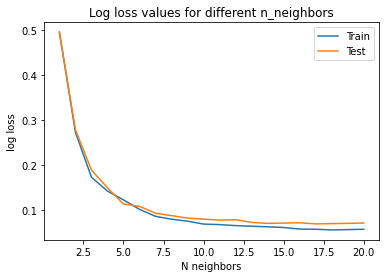

In [10]:
# Plot the graph
# Train lineplot
plt.plot(n_values, np.array(knn_log_loss_values)[:, 0], label='Train')
# Test lineplot
plt.plot(n_values, np.array(knn_log_loss_values)[:, 1], label='Test')

plt.title('Log loss values for different n_neighbors')
plt.xlabel('N neighbors')
plt.ylabel('log loss')
plt.legend()
plt.show()

In [11]:
np.array(knn_log_loss_values)[:, 1].min()

0.0688959900337229

Model performance in test data is best when `n_neighors` = 17, and it also performs good on train data.

This will be the value for n_neighbors henceforth.

For the final KNN I am going to use:
- `weights` = distance 
- `n_neighbors` = 17

In [42]:
# Instantiate the model
final_KNN = KNeighborsClassifier(weights='distance', n_neighbors=17)
final_KNN.fit(X_train_scaled, y_train)

# The final model scores are:
print("Train: ", knn_log_loss_values[-4][0], " Test: ", knn_log_loss_values[-4][1])

Train:  0.05699220146967311  Test:  0.0688959900337229


## 4. Build a Baseline Decision Tree Model

Now that you have chosen your best kNN model, start investigating decision tree models. First, build and evaluate a baseline decision tree model, using default hyperparameters (with the exception of `random_state=42` for reproducibility).

(Use cross-validated log loss, just like with the previous models.)

In [14]:
# Your code here
from sklearn.tree import DecisionTreeClassifier

# Instantiate the baseline model
baseline_treeModel = DecisionTreeClassifier(random_state=42)
# Fit the model
baseline_treeModel.fit(X_train, y_train)

# perform cross validation with train data
baseline_treeModel_logloss = -(cross_val_score(baseline_treeModel, X_train, y_train, scoring='neg_log_loss').mean())
probs_basetree = baseline_treeModel.predict_proba(X_test)

# compare model scores on test data and train data
print('train:' + str(baseline_treeModel_logloss) + ', test:' + str(log_loss(y_test, probs_basetree)))

train:0.7045390124149022, test:0.7499069464508977


Interpret this score. How does this compare to the log loss from our best logistic regression and best kNN models? Any guesses about why?

In [15]:
# Replace None with appropriate text
"""
The log loss value is really high, showing that underfitting is occurring. \
This shows that this model performs very badly compared to the other ones I've done before.

The reason could be because of the imbalance of the target classes. \
A good solution would be applying SMOTE to balance them out. 

However for uniformity of data used by both KNN and tree classification, I will not balance out the classes.
""".strip('\n')

"The log loss value is really high, showing that underfitting is occurring. This shows that this model performs very badly compared to the other ones I've done before.\n\nThe reason could be because of the imbalance of the target classes. A good solution would be applying SMOTE to balance them out. \n\nHowever for uniformity of data used by both KNN and tree classification, I will not balance out the classes."

## 5. Build Iterative Models to Find the Best Decision Tree Model

Build and evaluate at least two more decision tree models to find the best one. Explain why you are changing the hyperparameters you are changing as you go.

In [16]:
# Your code here (add more cells as needed)
# I am going to loop through possible values of depth to find what depth value minimizes log loss
depthLog_loss = []

for number in range(1, 21):
    # initialize, fit and predict using the model
    depthModel = DecisionTreeClassifier(max_depth=number, random_state=42)
    depthModel.fit(X_train, y_train)
    depth_probs = depthModel.predict_proba(X_test)
    
    # perform cross validation
    depth_logLoss_train = -(cross_val_score(depthModel, X_train, y_train, scoring='neg_log_loss').mean())
    depth_logLoss_test = log_loss(y_test, depth_probs)
    
    depthlog_losses = (depth_logLoss_train, depth_logLoss_test)
    depthLog_loss.append(depthlog_losses)
    
depthLog_loss

[(0.21122323200787632, 0.20991496034827642),
 (0.17110532803415182, 0.17109786337332286),
 (0.14950086433739623, 0.14895015736296566),
 (0.13012531033354707, 0.12065663150353584),
 (0.11887320104683834, 0.11431060234382939),
 (0.11373109144661545, 0.12145368938759403),
 (0.12805293103203358, 0.155243890041485),
 (0.18320301245225995, 0.1825011164095908),
 (0.260777212218576, 0.2441607921147766),
 (0.3335749181700383, 0.320972831890587),
 (0.44412404775328973, 0.4045088501868547),
 (0.5151560369994281, 0.4156483782722059),
 (0.5446884638139183, 0.5239047537585745),
 (0.5963696720563465, 0.5090854496748229),
 (0.6274716707103372, 0.6348010184487832),
 (0.65525320265541, 0.6888019194632237),
 (0.6888162629632417, 0.7193177354475213),
 (0.6989193601528568, 0.6929298490859266),
 (0.6958556479098774, 0.7499069464508977),
 (0.6896275555586504, 0.7499069464508977)]

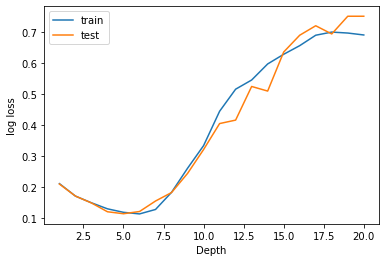

In [17]:
# plot the graph of the above variations
# train log_loss
plt.plot(range(1, 21), np.array(depthLog_loss)[:, 0], label='train')
# test log_loss
plt.plot(range(1, 21), np.array(depthLog_loss)[:, 1], label='test')

plt.xlabel('Depth')
plt.ylabel('log loss')
plt.legend()
plt.show()

In [19]:
np.array(depthLog_loss)[:, 1].min()

0.11431060234382939

The min log loss score for test data corresponds to `max_depth` = 5. Thats what I'm going to use.

In [23]:
# Next I am going to investigate the effect of different values of min_samples_split on log loss
splitLog_loss = []
for number in range(2, 31):
    # initialize, fit and predict using the model
    splitModel = DecisionTreeClassifier(max_depth=5, random_state=42, min_samples_split=number)
    splitModel.fit(X_train, y_train)
    split_probs = splitModel.predict_proba(X_test)
    
    # perform cross validation
    split_logLoss_train = -(cross_val_score(splitModel, X_train, y_train, scoring='neg_log_loss').mean())
    split_logLoss_test = log_loss(y_test, split_probs)
    
    splitlog_losses = (split_logLoss_train, split_logLoss_test)
    splitLog_loss.append(splitlog_losses)
    
splitLog_loss

[(0.11887320104683834, 0.11431060234382939),
 (0.11887320104683834, 0.11431060234382939),
 (0.11887320104683834, 0.11431060234382939),
 (0.11887320104683834, 0.11431060234382939),
 (0.11887320104683834, 0.11431060234382939),
 (0.11887320104683834, 0.11431060234382939),
 (0.11887320104683834, 0.11431060234382939),
 (0.11887320104683834, 0.11431060234382939),
 (0.11887320104683834, 0.11431060234382939),
 (0.11887320104683834, 0.11431060234382939),
 (0.11887320104683834, 0.11431060234382939),
 (0.11887320104683834, 0.11431060234382939),
 (0.11887320104683834, 0.11431060234382939),
 (0.11887320104683834, 0.11431060234382939),
 (0.11887320104683834, 0.11431060234382939),
 (0.11887320104683834, 0.11431060234382939),
 (0.11887320104683834, 0.11431060234382939),
 (0.11887320104683834, 0.11431060234382939),
 (0.11887320104683834, 0.11431060234382939),
 (0.11887320104683834, 0.11431060234382939),
 (0.11887320104683834, 0.11431060234382939),
 (0.11887320104683834, 0.11431060234382939),
 (0.118873

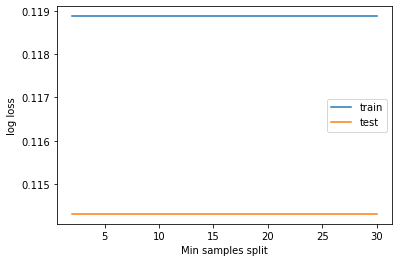

In [25]:
# plot the graph of the above variations
# train log_loss
plt.plot(range(2, 31), np.array(splitLog_loss)[:, 0], label='train')
# test log_loss
plt.plot(range(2, 31), np.array(splitLog_loss)[:, 1], label='test')

plt.xlabel('Min samples split')
plt.ylabel('log loss')
plt.legend()
plt.show()

The scores are constant for the variable numbers we used for min_samples_split. So I am just going to use the default.

The optimum hyperparameters for my tree classifier are:
- `min_samples_split` = 2
- `max_depth` = 5
- The rest are defaults

In [27]:
# Create the final tree classifier model
final_treeModel = DecisionTreeClassifier(random_state=42, min_samples_split=2, max_depth=5)

# fit the model to train data
final_treeModel.fit(X_train, y_train)

# The scores for this model are:
print('Train:', splitLog_loss[0][0], ', Test:', splitLog_loss[0][1])

Train: 0.11887320104683834 , Test: 0.11431060234382939


## 6. Choose and Evaluate an Overall Best Model

Which model had the best performance? What type of model was it?

Instantiate a variable `final_model` using your best model with the best hyperparameters.

In [28]:
# Replace None with appropriate code
final_model = KNeighborsClassifier(weights='distance', n_neighbors=17)

# Fit the model on the full training data
# (scaled or unscaled depending on the model)
final_model.fit(X_train_scaled, y_train)


KNeighborsClassifier(n_neighbors=17, weights='distance')

Now, evaluate the log loss, accuracy, precision, and recall. This code is mostly filled in for you, but you need to replace `None` with either `X_test` or `X_test_scaled` depending on the model you chose.

In [29]:
# Replace None with appropriate code
from sklearn.metrics import accuracy_score, precision_score, recall_score

preds = final_model.predict(X_test_scaled)
probs = final_model.predict_proba(X_test_scaled)

print("log loss: ", log_loss(y_test, probs))
print("accuracy: ", accuracy_score(y_test, preds))
print("precision:", precision_score(y_test, preds))
print("recall:   ", recall_score(y_test, preds))

log loss:  0.0688959900337229
accuracy:  0.9794307084978184
precision: 0.9123102866779089
recall:    0.7874818049490538


Interpret your model performance. How would it perform on different kinds of tasks? How much better is it than a "dummy" model that always chooses the majority class, or the logistic regression described at the start of the lab?

In [43]:
# Replace None with appropriate text
"""
The model performs very nicely. Compared to the logistic model and also a dummy model, this model is way better. \
\
If a record should be in Cover_Type 1, the model correctly classifies it ~79% of the time. \
Then, if the model predicts a record as belonging to Cover_Type 1, it is correct about the prediction ~91% of the time.
"""

'\nThe model performs very nicely. Compared to the logistic model and also a dummy model, this model is way better. If a record should be in Cover_Type 1, the model correctly classifies it ~79% of the time. Then, if the model predicts a record as belonging to Cover_Type 1, it is correct about the prediction ~91% of the time.\n'

## Conclusion

In this lab, you practiced the end-to-end machine learning process with multiple model algorithms, including tuning the hyperparameters for those different algorithms. You saw how nonparametric models can be more flexible than linear models, potentially leading to overfitting but also potentially reducing underfitting by being able to learn non-linear relationships between variables. You also likely saw how there can be a tradeoff between speed and performance, with good metrics correlating with slow speeds.